In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, 
                                               mean_proc=None, test_size=0.1, img_size=299)

# InceptionResNetV2 Fine Tuning

In [3]:
model_name = 'InceptionResNetV2'

base_model = InceptionResNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/100
167/168 [============================>.] - ETA: 0s - loss: 2.4430 - acc: 0.2240
Epoch 00001: val_loss improved from inf to 1.87525, saving model to ./saved_models/InceptionResNetV2.h5
168/168 [==============================] - 273s 2s/step - loss: 2.4388 - acc: 0.2260 - val_loss: 1.8753 - val_acc: 0.5753
Epoch 2/100
167/168 [============================>.] - ETA: 0s - loss: 1.3535 - acc: 0.6517
Epoch 00002: val_loss improved from 1.87525 to 0.82105, saving model to ./saved_models/InceptionResNetV2.h5
168/168 [==============================] - 77s 460ms/step - loss: 1.3493 - acc: 0.6530 - val_loss: 0.8210 - val_acc: 0.8361
Epoch 3/100
167/168 [============================>.] - ETA: 0s - loss: 0.6965 - acc: 0.8165
Epoch 00003: val_loss improved from 0.82105 to 0.40118, saving model to ./saved_models/InceptionResNetV2.h5
168/168 [==============================] - 77s 461ms/step - loss: 0.6955 - acc: 0.8168 - val_loss: 0.4012 - val_acc: 0.8896
Epoch 4/100
167/168 [=============

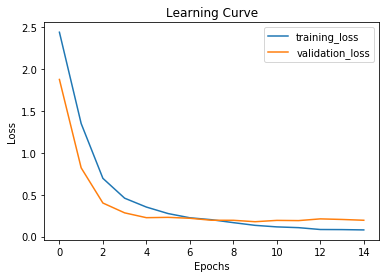

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

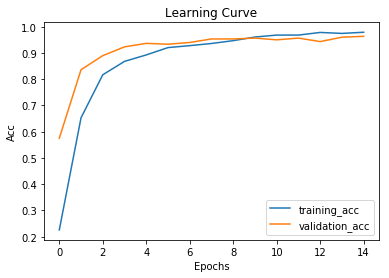

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 9s 29ms/step
Validation loss: 0.17815699017790448
Validation accuracy: 0.9565217391304348
